# Jet classification with Bayesian CNNs

In this tutorial we will build a Bayesian Convolutional Neural Network (CNN) and use the network for jet classification.

Much of what we code here will, as always, borrow code from previous tutorials.
The new material is mostly in constructing the Bayesian convolutional layer and the Bayesian CNN.
Constructing the Bayesian convolutional layer is quite advanced, so we don't expect you to have this done before the tutorial, instead you should focus on understanding each line in the code so that you would be able to take this and adapt it for your own research needs.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
 - Preprocessing
 - Visualising the data
 - Datasets and dataloaders
 - Building a Bayesian layer
 - Building a Bayesian convolutional layer
 - Building the Bayesian CNN
 - Optimising the CNN
 - Plot the train and validation losses
 - Study the results - plot the ROC curve
 - Uncertainties from a Bayesian CNN

### Imports

In [1]:
import os
import sys
import random
import time
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
from torch.nn import Parameter

In [2]:
from pd4ml import TopTagging

#### Plotting set-up

In [3]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(22)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Load the data

Load the data we saved out in the previous tutorial.

In [4]:
X_train = np.load( "tutorial-3-data/TopTagging/x_train_short.npy")
y_train = np.load( "tutorial-3-data/TopTagging/y_train_short.npy")
X_test = np.load( "tutorial-3-data/TopTagging/x_test_short.npy")
y_test = np.load( "tutorial-3-data/TopTagging/y_test_short.npy")
X_val = np.load( "tutorial-3-data/TopTagging/x_val_short.npy")
y_val = np.load( "tutorial-3-data/TopTagging/y_val_short.npy")

## Preprocessing

In [6]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) )
    
    return z_out

In [7]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


## Visualising the data

In [7]:
sig = z_train[ np.where(y_train==1) ]
bkg = z_train[ np.where(y_train==0) ]

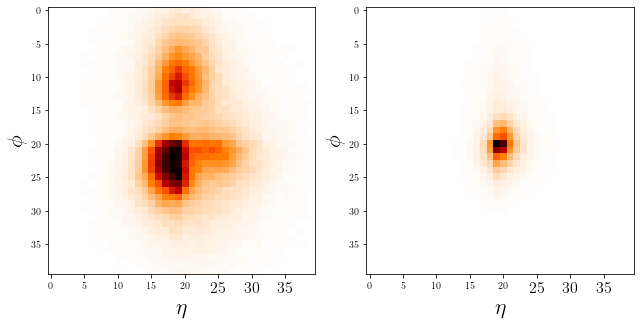

In [8]:
fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig.mean(0).reshape( (40,40) ), cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$", fontproperties=axislabelfont )
axs[0].set_ylabel( "$\phi$", fontproperties=axislabelfont )
ticks0 = [ int(x) for x in axs[0].get_yticks() ]
axs[0].set_yticklabels( ticks0, fontproperties=tickfont )
axs[0].set_xticklabels( ticks0, fontproperties=tickfont )

axs[1].imshow( bkg.mean(0).reshape( (40,40) ), cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$", fontproperties=axislabelfont )
axs[1].set_ylabel( "$\phi$", fontproperties=axislabelfont )
ticks1 = [ int(x) for x in axs[1].get_yticks() ]
axs[1].set_yticklabels( ticks1, fontproperties=tickfont )
axs[1].set_xticklabels( ticks1, fontproperties=tickfont )

fig.tight_layout()

fig.show()

## Datasets and dataloaders

In [9]:
class cnn_data( Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__( self ):
        return len(self.labels)

    def __getitem__( self, idx ):
        return self.imgs[idx], self.labels[idx]

In [10]:
z_train = torch.Tensor( z_train.reshape(-1, 1, 40,40).astype('float32') )
z_test = torch.Tensor( z_test.reshape(-1, 1, 40,40).astype('float32') )
z_val = torch.Tensor( z_val.reshape(-1, 1, 40,40).astype('float32') )

In [11]:
y_train = torch.Tensor( y_train ).unsqueeze( -1 )
y_test = torch.Tensor( y_test ).unsqueeze( -1 )
y_val = torch.Tensor( y_val ).unsqueeze( -1 )

In [12]:
train_cnn_dataset = cnn_data( z_train, y_train.float() )
test_cnn_dataset = cnn_data( z_test, y_test.float() )
val_cnn_dataset = cnn_data( z_val, y_val.float() )

In [13]:
train_cnn_dataloader = DataLoader( train_cnn_dataset, batch_size=64, shuffle=True )
test_cnn_dataloader = DataLoader( test_cnn_dataset, batch_size=64, shuffle=True )
val_cnn_dataloader = DataLoader( val_cnn_dataset, batch_size=64, shuffle=True)

In [19]:
(X, y) = next(iter(train_cnn_dataloader))
print(y.shape)

torch.Size([64, 1])


## Building a Bayesian layer

We will just take the layer from the Bayesian network tutorial.

In [20]:
class VBLinear( Module ):
    # VB -> Variational Bayes
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    
    def __init__( self, in_features, out_features ):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = Parameter( Tensor( out_features ) )
        self.mu_w = Parameter( Tensor( out_features, in_features ) )
        self.logsig2_w = Parameter( Tensor( out_features, in_features ) )
        self.random = torch.randn_like( self.logsig2_w )
        self.reset_parameters()
        
    def forward( self, input ):
        if self.resample:
            self.random = torch.randn_like( self.logsig2_w )
        s2_w = self.logsig2_w.exp()
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear( input, weight, self.bias ) #+ 1e-8
    
    def reset_parameters( self ):
        stdv = 1. / np.sqrt( self.mu_w.size(1) )
        self.mu_w.data.normal_( 0, stdv )
        self.logsig2_w.data.zero_().normal_( -9, 0.001 )
        self.bias.data.zero_()
        
    def KL( self, loguniform=False ):
        kl = 0.5 * ( self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1 ).sum()
        return kl

## Building a Bayesian convolutional layer

First let's look at a regular convolutional layer, as defined in pytorch.

Applies a 2D convolution over an input signal composed of several input planes.
In the simplest case, the output value of the layer with input size $(N, C_{\text{in}}, H, W)$ and output $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$ can be precisely described as:

$
\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
\sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
$

where $\star$ is the valid 2D cross-correlation operator, $N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels.

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
- `stride` controls the stride for the cross-correlation, a single number or a tuple.
- `padding` controls the amount of padding applied to the input. It can be either a string {{'valid', 'same'}} or a tuple of ints giving the amount of implicit padding applied on both sides.
- `dilation` controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this `link` has a nice visualization of what `dilation` does.

The parameters :attr:`kernel_size`, :attr:`stride`, :attr:`padding`, :attr:`dilation` can either be:

- a single ``int`` -- in which case the same value is used for the height and width dimension
- a ``tuple`` of two ints -- in which case, the first `int` is used for the height dimension, and the second `int` for the width dimension

Note: ``padding='valid'`` is the same as no padding. ``padding='same'`` pads the input so the output has the shape as the input. However, this mode doesn't support any stride values other than 1.

Args:
- in_channels (int): Number of channels in the input image
- out_channels (int): Number of channels produced by the convolution
- kernel_size (int or tuple): Size of the convolving kernel
- stride (int or tuple, optional): Stride of the convolution. Default: 1
- padding (int, tuple or str, optional): Padding added to all four sides of
    the input. Default: 0
- padding_mode (string, optional): ``'zeros'``, ``'reflect'``,
    ``'replicate'`` or ``'circular'``. Default: ``'zeros'``
- dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
- groups (int, optional): Number of blocked connections from input
    channels to output channels. Default: 1
- bias (bool, optional): If ``True``, adds a learnable bias to the
    output. Default: ``True``

Shape:
- Input: $(N, C_{in}, H_{in}, W_{in})$ or $(C_{in}, H_{in}, W_{in})$
- Output: $(N, C_{out}, H_{out}, W_{out})$ or $(C_{out}, H_{out}, W_{out})$, where

$
H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
        \times (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor
$

$
W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
        \times (\text{kernel_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor
$

Attributes:
- weight (Tensor): the learnable weights of the module of shape
    $(\text{out_channels}$, $\frac{\text{in_channels}}{\text{groups}}$,
    $\text{kernel_size[0]}$, $\text{kernel_size[1]})$.
    The values of these weights are sampled from
    $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where
    $k = \frac{groups}{C_\text{in} * \prod_{i=0}^{1}\text{kernel_size}[i]}$
- bias (Tensor):   the learnable bias of the module of shape
    (out_channels). If :attr:`bias` is ``True``,
    then the values of these weights are
    sampled from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where
    $k = \frac{groups}{C_\text{in} * \prod_{i=0}^{1}\text{kernel_size}[i]}$

Examples:

\>>> # With square kernels and equal stride

\>>> m = nn.Conv2d(16, 33, 3, stride=2

\>>> # non-square kernels and unequal stride and with padding

\>>> m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))

\>>> # non-square kernels and unequal stride and with padding and dilation

\>>> m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))

\>>> input = torch.randn(20, 16, 50, 100)

\>>> output = m(input)

In [21]:
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from typing import Optional, List, Tuple, Union

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
        ...

    _in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, ...],
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilation: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 device=None,
                 dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")

        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
            if padding == 'same':
                for d, k, i in zip(dilation, kernel_size,
                                   range(len(kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (
                        total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

        if transposed:
            self.weight = Parameter(torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
        else:
            self.weight = Parameter(torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'


class Conv2d(_ConvNd):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)

In constructing the Bayesian layer we use code from:

https://github.com/kumar-shridhar/PyTorch-BayesianCNN

In research we regularly use code hosted on public sites such as github or gitlab.  Knowing how to find, read, and interpret this code, and then adapt it for your own research is important.

In [22]:
class ModuleWrapper(nn.Module):
    """Wrapper for nn.Module with support for arbitrary flags and a universal forward pass"""

    def __init__(self):
        super(ModuleWrapper, self).__init__()

    def set_flag(self, flag_name, value):
        setattr(self, flag_name, value)
        for m in self.children():
            if hasattr(m, 'set_flag'):
                m.set_flag(flag_name, value)

    def forward(self, x):
        for module in self.children():
            x = module(x)

        kl = 0.0
        for module in self.modules():
            if hasattr(module, 'kl_loss'):
                kl = kl + module.kl_loss()

        return x, kl
    
def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

class BBBConv2d(ModuleWrapper):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None):

        super(BBBConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        self.W_mu = Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))
        self.W_rho = Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        if self.training or sample:
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))
            weight = self.W_mu + W_eps * self.W_sigma

            if self.use_bias:
                bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
                self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
                bias = self.bias_mu + bias_eps * self.bias_sigma
            else:
                bias = None
        else:
            weight = self.W_mu
            bias = self.bias_mu if self.use_bias else None

        return F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)

    def KL(self):
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

The code for the Bayesian convolutional layer might look much ligher than the code for the regular convolutional layer.  But the ConvND class defined in pytorch is much more general than the class for the Bayesian convolutional layer, so the Bayesian code looks more compact.

## Building the Bayesian CNN

We build the Bayesian CNN using aspects of both the CNN and the Bayesian networks studied in previous tutorials.

In [23]:
class BayesConvNet2D(nn.Module):
    
    def __init__(self, training_size=None, in_ch=1, ch=4, out_dim=1, img_sz=40):
        super().__init__()
        self.training_size = training_size
        
        self.vb_layers = []
        self.all_layers = []
        
        self.conv1 = BBBConv2d(in_ch, ch, kernel_size=5, bias=True, stride=1, padding=2)
        self.vb_layers.append( self.conv1 )
        self.all_layers.append( self.conv1 )
        
        self.all_layers.append( nn.ReLU() )
        
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.all_layers.append( self.max1 )
        
        self.all_layers.append( nn.ReLU() )
        
        self.conv2 = BBBConv2d(ch, 1, kernel_size=5, bias=True, stride=1, padding=2)
        self.vb_layers.append( self.conv2 )
        self.all_layers.append( self.conv2 )
        
        self.max2 = nn.MaxPool2d(kernel_size=2)
        self.all_layers.append( self.max2 )
        
        self.flatten = nn.Flatten()
        self.all_layers.append( self.flatten )
        
        self.out = VBLinear( int(img_sz*img_sz/16), out_dim )
        self.vb_layers.append( self.out )
        self.all_layers.append( self.out )
        
        self.all_layers.append( nn.Sigmoid() )
    
    # the forward function
    def forward(self, x):
        self.net = nn.Sequential(*self.all_layers)
        return self.net(x)
    
    # we need the KL from the bayesian layers to compute the loss function
    def KL( self ):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


We can test the network by passing through an image:

In [25]:
test_net = BayesConvNet2D()

In [26]:
np.shape( train_cnn_dataset[0][0] )

torch.Size([1, 40, 40])

In [27]:
test_net( train_cnn_dataset[0][0].unsqueeze(0) )

tensor([[0.5689]], grad_fn=<SigmoidBackward0>)

## Optimizing the Bayesian CNN

The training procedures and loops are exactly as they are in the Bayesian NN tutorial.

In [45]:
def train_epoch( dataloader, model, optimizer ):

    size = len( dataloader.dataset )
    model.train()
    loss_tot, kl_tot, neg_log_tot = 0.0, 0.0, 0.0
    
    for batch, (X, y) in enumerate( dataloader ):
        
        # pass data through network
        pred = model(X)
        
        # compute loss
        #nl = model.neg_log_gauss( pred, y.reshape(-1) )
        #nl = model.cross_entropy(pred, y)
        loss = nn.BCELoss()

        nl = loss(pred, y)
        kl = model.KL()
        loss = nl + kl
        
        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            current = batch * len( X )
            print(f"current batch loss: {loss:>8f} KL: {kl:>8f} Neg-log {nl:>8f}  [{current:>5d}/{size:>5d}]")

In [46]:
def val_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    nls = 0.0
    kls = 0.0
    vls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            loss = nn.BCELoss()
            nl = loss(pred, y)
            kl = model.KL()
            vl = nl.item() + kl.item()
            nls += nl
            kls += kl
            vls += vl

    nls /= num_batches
    kls /= num_batches
    vls /= num_batches
    print( f"avg val loss per batch: {vls:>8f} KL: {kls:>8f} Neg-log {nls:>8f}" )
    
    return nls, kls, vls

def trn_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    nls = 0.0
    kls = 0.0
    tls = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            loss = nn.BCELoss()
            nl = loss(pred, y)
            kl = model.KL()
            tl = nl.item() + kl.item()
            nls += nl
            kls += kl
            tls += tl

    nls /= num_batches
    kls /= num_batches
    tls /= num_batches
    print( f"avg trn loss per batch: {tls:>8f} KL: {kls:>8f} Neg-log {nls:>8f}" )
    
    return nls, kls, tls

The training loop is pretty much exactly the same as in the Bayesian NN section.

In [47]:
# a useful function to present things clearer
def separator():
    print( "-----------------------------------------------" )

# reset some parameters
batch_size = 128
epochs = 50

# re-initialise the model and the optimizer
hdn_dim = 50
trn_len = y_train.shape[0]
print(f"Training dataset length: {trn_len}")
model = BayesConvNet2D( training_size=trn_len, ch=4 ).to(device)
learning_rate = 5e-4
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )
separator()
print( "model architecture ")
separator()
print( model )

# track train and val losses
trn_nl_losses = []
trn_kl_losses = []
trn_losses = []
trn_mse_losses = []
val_nl_losses = []
val_kl_losses = []
val_losses = []
val_mse_losses = []

for t in range(epochs):
    separator()
    print( f"Epoch {t+1}" )
    separator()
    train_epoch( train_cnn_dataloader, model, optimizer )
    separator()
    trn_nl_loss, trn_kl_loss, trn_loss = trn_pass( train_cnn_dataloader, model )
    trn_nl_losses.append( trn_nl_loss )
    trn_kl_losses.append( trn_kl_loss )
    trn_losses.append( trn_loss )
    separator()
    val_nl_loss, val_kl_loss, val_loss = val_pass( val_cnn_dataloader, model )
    val_nl_losses.append( val_nl_loss )
    val_kl_losses.append( val_kl_loss )
    val_losses.append( val_loss )
    separator()
    print( "|" )
    
print("Done!")

Training dataset length: 30000
-----------------------------------------------
model architecture 
-----------------------------------------------
BayesConvNet2D(
  (conv1): BBBConv2d()
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): VBLinear()
)
-----------------------------------------------
Epoch 1
-----------------------------------------------
current batch loss: 0.726327 KL: 0.034173 Neg-log 0.692154  [    0/30000]
current batch loss: 0.718027 KL: 0.026036 Neg-log 0.691991  [ 6400/30000]
current batch loss: 0.709180 KL: 0.022985 Neg-log 0.686195  [12800/30000]
current batch loss: 0.704085 KL: 0.023934 Neg-log 0.680151  [19200/30000]
current batch loss: 0.652678 KL: 0.032334 Neg-log 0.620344  [25600/30000]
-----------------------------------------------
avg trn loss per batch: 0.58659

## Plot train and validation losses

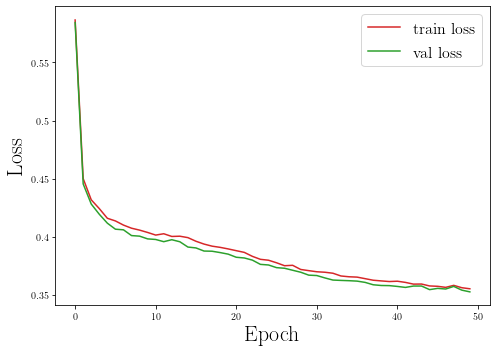

In [48]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs.plot( trn_losses, label="train loss", color=c1 )
axs.plot( val_losses, label="val   loss", color=c2 )

#axs.set_yscale('log')

axs.set_xlabel( "Epoch", fontproperties=axislabelfont )
axs.set_ylabel( "Loss", fontproperties=axislabelfont )

xticks = [ int(x) for x in axs.get_xticks() ]
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = [ np.round(x,2) for x in axs.get_yticks() ]
axs.set_yticklabels( yticks, fontproperties=tickfont )

axs.legend( loc='best', prop=tickfont )

fig.tight_layout()

In [49]:
trn_loss = trn_pass( train_cnn_dataloader, model )
val_loss = val_pass( test_cnn_dataloader, model )
test_loss = val_pass( val_cnn_dataloader, model )

avg trn loss per batch: 0.355418 KL: 0.023654 Neg-log 0.331764
avg val loss per batch: 0.357542 KL: 0.023654 Neg-log 0.333889
avg val loss per batch: 0.353128 KL: 0.023654 Neg-log 0.329474


In [50]:
def get_prediction(x, model, n_monte=30):
    
    pred = []
    for i in range(n_monte):
        print(f"Computing Monte Carlo sample {i+1} / {n_monte}")
        pred.append(model(x)[:,0].detach().unsqueeze(1))
        
    pred = torch.stack(pred)
    mean = torch.mean(pred, axis=0)
    std = torch.std(pred, axis=0)
    
    return mean, std

In [51]:
samp_size = 10000

train_true = y_train[:samp_size]
test_true = y_test[:samp_size]
val_true = y_val[:samp_size]

# let's ignore the uncertainties for now and concentrate on the average prediction
train_pred, _ = get_prediction(z_train[:samp_size], model, n_monte=10)
test_pred, _ = get_prediction(z_test[:samp_size], model, n_monte=10)
val_pred, _ = get_prediction(z_val[:samp_size], model, n_monte=10)

train_pred_lab = torch.round(train_pred[:samp_size])
test_pred_lab = torch.round(test_pred[:samp_size])
val_pred_lab = torch.round(val_pred[:samp_size])

train_correct = (train_pred_lab==y_train[:samp_size]).sum().item()
test_correct = (test_pred_lab==y_test[:samp_size]).sum().item()
val_correct = (val_pred_lab==y_val[:samp_size]).sum().item()

Computing Monte Carlo sample 1 / 10
Computing Monte Carlo sample 2 / 10
Computing Monte Carlo sample 3 / 10
Computing Monte Carlo sample 4 / 10
Computing Monte Carlo sample 5 / 10
Computing Monte Carlo sample 6 / 10
Computing Monte Carlo sample 7 / 10
Computing Monte Carlo sample 8 / 10
Computing Monte Carlo sample 9 / 10
Computing Monte Carlo sample 10 / 10
Computing Monte Carlo sample 1 / 10
Computing Monte Carlo sample 2 / 10
Computing Monte Carlo sample 3 / 10
Computing Monte Carlo sample 4 / 10
Computing Monte Carlo sample 5 / 10
Computing Monte Carlo sample 6 / 10
Computing Monte Carlo sample 7 / 10
Computing Monte Carlo sample 8 / 10
Computing Monte Carlo sample 9 / 10
Computing Monte Carlo sample 10 / 10
Computing Monte Carlo sample 1 / 10
Computing Monte Carlo sample 2 / 10
Computing Monte Carlo sample 3 / 10
Computing Monte Carlo sample 4 / 10
Computing Monte Carlo sample 5 / 10
Computing Monte Carlo sample 6 / 10
Computing Monte Carlo sample 7 / 10
Computing Monte Carlo samp

In [52]:
separator()
print('Evaluation of accuracy: ')
print('Accuracy on training dataset: {:.1f} %'.format(train_correct*100/len(train_pred)))
print('Accuracy on validation dataset: {:.1f} %'.format(val_correct*100/len(val_pred)))
print('Accuracy on test dataset: {:.1f} %'.format(test_correct*100/len(test_pred)))
separator()

-----------------------------------------------
Evaluation of accuracy: 
Accuracy on training dataset: 85.9 %
Accuracy on validation dataset: 86.5 %
Accuracy on test dataset: 85.8 %
-----------------------------------------------


## Study the results - plot the ROC curve

Just as in the CNN tutorial, we can plot the ROC curve to visualise the performance of the model.

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

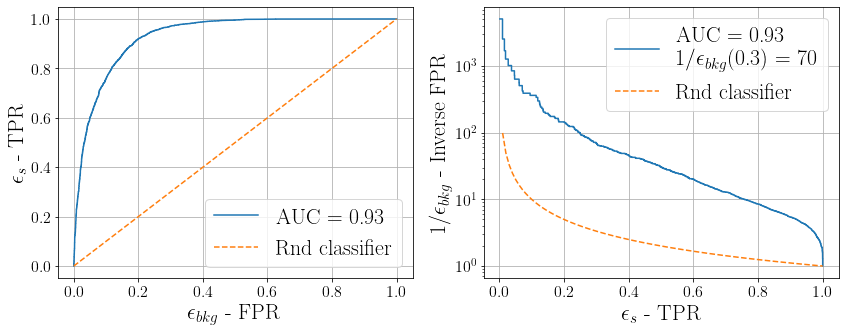

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

fpr, tpr, th = roc_curve(test_true, test_pred)
auc_score = roc_auc_score(test_true, test_pred)
rnd_class = np.linspace(0, 1, 100)

ax[0].plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score) )
ax[0].plot(rnd_class, rnd_class, '--', label='Rnd classifier')
ax[1].plot(tpr, 1/fpr, label='AUC = {:.2f}\n $1/\epsilon_{{bkg}}$(0.3) = {:.0f}'.format(auc_score, 1/fpr[closest_point(tpr, tpr_p=0.3)]))
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Rnd classifier')
ax[1].set_yscale('log')

ax[0].set_xlabel('$\epsilon_{bkg}$ - FPR', fontproperties=axislabelfont)
ax[0].set_ylabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)

ax[1].set_xlabel('$\epsilon_{s}$ - TPR', fontproperties=axislabelfont)
ax[1].set_ylabel('1/$\epsilon_{bkg}$ - Inverse FPR', fontproperties=axislabelfont)
for i in range(len(ax)):
    ax[i].legend(prop=axislabelfont)
    ax[i].tick_params(labelsize=axisfontsize)
    ax[i].grid('on')

## Uncertainties from the Bayesian CNN

By sampling from the weight distributions of a Bayesian neural network we get several predictions for the same input image. The standard deviation of these predictions provides us with an uncetrainty estimate.

Let's have a look at the distribution of uncertainties for the test dataset and see how it is correlated with the average prediction.

Computing Monte Carlo sample 1 / 10
Computing Monte Carlo sample 2 / 10
Computing Monte Carlo sample 3 / 10
Computing Monte Carlo sample 4 / 10
Computing Monte Carlo sample 5 / 10
Computing Monte Carlo sample 6 / 10
Computing Monte Carlo sample 7 / 10
Computing Monte Carlo sample 8 / 10
Computing Monte Carlo sample 9 / 10
Computing Monte Carlo sample 10 / 10


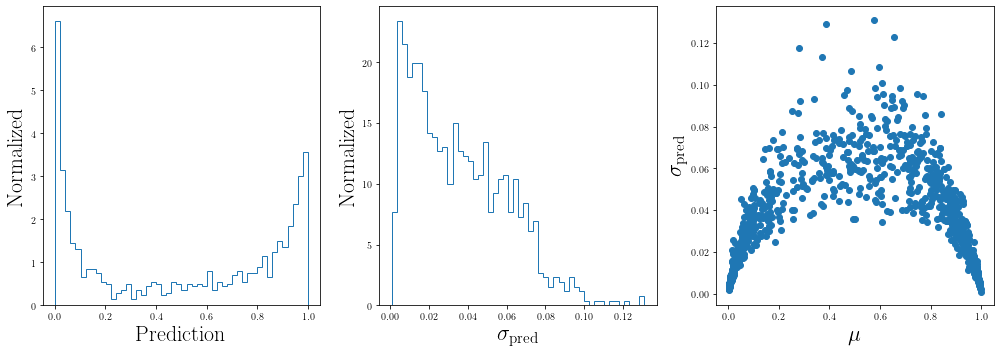

In [56]:
samp_size = 1000

test_pred, test_std = get_prediction(z_test[:samp_size], model, n_monte=10)

fig, ax = plt.subplots(1, 3, figsize=(14,5))

test_std = test_std.reshape(-1).numpy()
test_pred = test_pred.reshape(-1).numpy()

ax[0].hist(test_pred, bins=50, histtype="step", density=True)
ax[0].set_xlabel('Prediction', fontproperties=axislabelfont)
ax[0].set_ylabel('Normalized', fontproperties=axislabelfont)

ax[1].hist(test_std, bins=50, histtype="step", density=True)
ax[1].set_xlabel(r'$\sigma_{\mathrm{pred}}$', fontproperties=axislabelfont)
ax[1].set_ylabel('Normalized', fontproperties=axislabelfont)

ax[2].scatter(test_pred, test_std)
ax[2].set_xlabel(r'$\mu$', fontproperties=axislabelfont)
ax[2].set_ylabel(r'$\sigma_{\mathrm{pred}}$', fontproperties=axislabelfont)
fig.tight_layout()

The first plot shows that the predictions are bound to the interval [0, 1] with peaks for the two classes. The second plot shows the distribution of uncertainties. From general considerations about bounded probability distributions the maximum sigma_pred can't exceed 0.5. The third plot shows the correlation between the mean prediction and the standard deviation. We can see that predictions close to 0 or 1 have small uncertainties. This makes sense because if a network outputs p=0.95 we expect it to be quite confident about its decision.